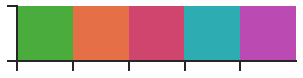

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import sqlalchemy
import mysql.connector
import re
from scipy import stats

# plot config 

sns.set_style('ticks')
SMALL = 14
MEDIUM = 16
LARGE = 18

# fonts
plt.rc('font', size=SMALL)          # controls default text sizes
plt.rc('axes', titlesize=LARGE, labelsize=MEDIUM)  # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

# axes/tick width
plt.rc('axes', linewidth=2) 
plt.rc('xtick.major', size=10, width=2)
plt.rc('ytick.major', size=10, width=2)
plt.rc('axes.spines', right=False, top=False)

# linewidth
plt.rc('lines', linewidth=2.5, markersize=14)
plt.rc('markers', fillstyle='none')

# see https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
# consider rcparams to override defaults? 


a = '#4BAC3E'
b = '#E56F47'
c = '#CF456D'
d = '#2DACB2'
e = '#BB4BB2'
colors = sns.color_palette([a,b,c,d,e])
green, orange, red, blue, purple = colors
sns.palplot(colors)


# London Marathon EDA
### Author: Elliot Quan

#### Description: Notebook containing EDA and data cleaning.

#### CTRL+F update to toggle read/write from sqlite database

In [9]:
# helper fxns

def df_selector(df, level, keywords):
    """Utility fxn to select the level and columns to search for a multiindex df.
    keywords must be a list of column names. If the list is length >1, it will perform exact matching.
    """
    if len(keywords) > 1:
        return df.loc[:, df.columns.get_level_values(level).isin(keywords)]
    return df.loc[:, df.columns.get_level_values(level).str.contains(keywords[0])]


def split_format(df, names = None, multi=False):
    """Convert all time columns in df from seconds to timedelta (HH:MM:SS)
    multi denotes MultiIndex columns, which will select split -> mean 
    otherwise, names will expect a list of column names containing split data
    
    """
    if multi:
        temp = df_selector(df, 0, ['split'])
        temp = df_selector(temp, 1, ['mean'])
        return temp.apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
    else:
        if names:
            return df.loc[:, names].apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
        temp = df_selector(df, 0, ['split'])
        return temp.apply(lambda x: pd.to_timedelta(x, unit='seconds', errors='coerce').dt.round('s'))
def CoV(x):
    """Coefficient of Variation = sd/mean*100 """
    return np.round(np.std(x)/np.mean(x)*100,1)



In [10]:
user = ''
pw = ''
ip = ''

engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{user}:{pw}@{ip}:3306/london19?charset=utf8")

sql = """SELECT * FROM runners;"""
df = pd.read_sql_query(sql=sql, con=engine)


# 2014-2017 only has a 70+ category, while 2018-2019 have 70-74, etc. so we need to combine those into 70+
df.loc[df['category'].isin(['70-74', '75-79', '80-84']), 'category'] = '70+'


# all dates are read as strings
# convert diff in MM:SS to datetime HH:MM:SS. any missing values are coerced to NaT
df.loc[:, df.columns.str.contains('diff')] = df.loc[:, df.columns.str.contains('diff')].apply(lambda x:
pd.to_datetime(x, format='%M:%S', errors='coerce').dt.time)

# convert all other splits in HH:MM:SS to datetime HH:MM:SS
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].apply(lambda x:
pd.to_datetime(x, format='%H:%M:%S', errors='coerce').dt.time)

# convert everything back to a string...
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].astype(str)

# finally, convert strings to timedelta, then obtain all times in total seconds
df.loc[:, df.columns.str.contains('split')] = df.loc[:, df.columns.str.contains('split')].apply(lambda x:
pd.to_timedelta(x, errors='coerce').dt.total_seconds())

df['split_Half2'] = df['split_Finish'] - df['split_Half']
df['split_25K_diff'] = df['split_Half_diff'] + df['split_25K_diff']
# it is MUCH easier to work with everything in terms of seconds, and then convert back
# to a human readable format after all operations are completed


# for each year and gender, assign a quartile (1,2,3,4) to each runner 
df = df.sort_values(by=['split_Finish'])
df['quartile'] = 1
 
for yr in [2014, 2015, 2016, 2017, 2018, 2019]:
    for g in ['M', 'F']:
        temp = df[(df['year']==yr) & (df['gender']==g)]['split_Finish']
        rank = [temp.quantile(.25), temp.quantile(.5), temp.quantile(.75)]
        df.loc[(df['year']==yr) & (df['gender']==g), 'quartile'] = [1 if time < rank[0] else 2 if time < rank[1] else 3 if time < rank[2] else 4 for time in temp]

# remove country and force lowercase
df['name'] = df['name'].str.replace(' \([A-Z]+\)', '').str.lower()


    
df.loc[:, df.columns.str.contains('split')].head()

,split_5K,split_5K_diff,split_10K,split_10K_diff,split_15K,split_15K_diff,split_20K,split_20K_diff,split_Half,split_Half_diff,...,split_25K_diff,split_30K,split_30K_diff,split_35K,split_35K_diff,split_40K,split_40K_diff,split_Finish,split_Finish_diff,split_Half2
110919,863.0,863.0,1741.0,879.0,2622.0,882.0,3505.0,883.0,3697.0,192.0,...,854.0,5224.0,867.0,6115.0,892.0,6980.0,866.0,7357.0,378.0,3660.0
73295,863.0,863.0,1742.0,879.0,2622.0,881.0,3505.0,883.0,3697.0,192.0,...,854.0,5224.0,866.0,6115.0,892.0,6982.0,867.0,7375.0,393.0,3678.0
115477,856.0,856.0,1717.0,861.0,2597.0,881.0,3490.0,894.0,3684.0,194.0,...,870.0,5233.0,875.0,6127.0,894.0,7009.0,883.0,7385.0,377.0,3701.0
214097,863.0,863.0,1742.0,879.0,2623.0,881.0,3505.0,883.0,3697.0,192.0,...,857.0,5224.0,863.0,6116.0,892.0,6989.0,873.0,7396.0,408.0,3699.0
18360,856.0,856.0,1717.0,861.0,2597.0,881.0,3491.0,894.0,3684.0,194.0,...,870.0,5233.0,874.0,6127.0,894.0,7018.0,892.0,7431.0,413.0,3747.0


In [11]:
df.shape

(234613, 34)

In [12]:
df.columns

Index(['index', 'name', 'country', 'club', 'category', 'id', 'place_gender',
       'place_category', 'place_overall', 'gender', 'elite', 'split_5K',
       'split_5K_diff', 'split_10K', 'split_10K_diff', 'split_15K',
       'split_15K_diff', 'split_20K', 'split_20K_diff', 'split_Half',
       'split_Half_diff', 'split_25K', 'split_25K_diff', 'split_30K',
       'split_30K_diff', 'split_35K', 'split_35K_diff', 'split_40K',
       'split_40K_diff', 'split_Finish', 'split_Finish_diff', 'year',
       'split_Half2', 'quartile'],
      dtype='object')

In [13]:
# display times at the top .1, 1, 5, 10, 25, 50, 75 percentiles

mdf = df[(df['gender']=='M') & (df['year']==2019)]
fdf = df[(df['gender']=='F') & (df['year']==2019)]
quantiles = [.001, .005, .01, .05, .10, .25, .50, .75]
mindices = np.quantile(np.arange(0, mdf.shape[0]), quantiles, interpolation='lower')
findices = np.quantile(np.arange(0, fdf.shape[0]), quantiles, interpolation='lower')

times = split_format(fdf, names=['split_Finish']).iloc[findices]
times = times.reset_index(drop=True)
times1 = split_format(mdf, names=['split_Finish']).iloc[mindices]
times1 = times1.reset_index(drop=True)
times['split_finish_m'] = times1['split_Finish']
times['top_percentile'] = np.array(quantiles)*100
times = times.loc[:, ['top_percentile', 'split_finish_m', 'split_Finish']]
res = ''
for r in np.arange(0,8):
    for c in np.arange(0,3):
        res += '|' + str(times.iloc[r,c])
    res += '|\n'
print(res)

|0.1|0 days 02:15:06|0 days 02:31:53|
|0.5|0 days 02:30:12|0 days 02:56:07|
|1.0|0 days 02:35:39|0 days 03:03:00|
|5.0|0 days 02:52:03|0 days 03:24:33|
|10.0|0 days 03:03:36|0 days 03:36:55|
|25.0|0 days 03:34:30|0 days 04:04:30|
|50.0|0 days 04:09:22|0 days 04:45:30|
|75.0|0 days 04:50:36|0 days 05:29:01|



In [14]:
# For 2019 runners: mark runners who ran at least once in 2014-2018
# default type none, T/F only for 2019 runners
# of course this is imperfect, but it is better than nothing


df['repeat'] = None
df['cat_int'] = df['category'].factorize()[0] # convert cat to numeric labels 0-7

# convert 3 fields (name, country, category as int) into a string,
df['namectynum_actual'] = df['name'] + df['country'] + df['cat_int'].astype('str')

# also check the previous age category to account for the fact that >5 years of data exist
df['namectynum2'] = df['name'] + df['country'] + (df['cat_int'] - 1).astype('str')

df19 = df.loc[df['year']==2019, ['namectynum_actual', 'namectynum2']]
dfother = df.loc[df['year']!= 2019, ['namectynum_actual', 'namectynum2']]

# test whether string appears at all in the dataset
cond = ((df19['namectynum_actual'].isin(dfother['namectynum_actual'])) | 
        (df19['namectynum_actual'].isin(dfother['namectynum2'])))

df.loc[df['year']==2019, 'repeat'] = cond

In [15]:
# look at average times by category

m = df.groupby(['year', 'elite', 'gender']).agg([np.mean, CoV])
m = df_selector(m, 0, ['split'])
m

/home/quan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


split_5K       split_5K_diff          split_10K  \
                             mean   CoV          mean   CoV         mean   
year elite    gender                                                       
2014 elite    F       1025.666667   2.7   1025.666667   2.7  2038.000000   
              M        887.888889   3.2    887.888889   3.2  1800.555556   
     nonelite F       1850.056008  15.5   1850.056008  15.5  3755.169472   
              M       1637.433757  16.7   1637.433757  16.7  3305.584342   
2015 elite    F       1031.777778   2.0   1031.777778   2.0  2050.333333   
              M        911.952381   3.9    911.952381   3.9  1830.142857   
     nonelite F       1845.622536  15.4   1845.491921  15.4  3722.475244   
              M       1628.140540  16.6   1628.140540  16.6  3273.045156   
2016 elite    F       1019.842105   2.4   1019.842105   2.4  2046.421053   
              M        906.629630   4.2    906.629630   4.2  1818.111111   
     nonelite F       1866.976424  15.7   1866.976424  15.7  3766.669846   
              M       1640.362624  17.3   1640.362624  17.3  3291.156331   
2017 elite    F       1012.807692   5.1   1012.807692   5.1  2040.923077   
              M        900.645161   4.0    900.645161   4.0  1827.225806   
     nonelite F       1866.484554  16.0   1866.484554  16.0  3779.580969   
              M       1631.480138  17.9   1631.480138  17.9  3292.152197   
2018 elite    F       1004.615385   4.3   1004.615385   4.3  2028.538462   
              M        876.388889   5.8    876.388889   5.8  1782.555556   
     nonelite F       1900.042558  17.4   1899.424799  17.3  3892.091979   
              M       1649.141709  18.5   1649.141709  18.5  3354.741777   
2019 elite    F       1023.857143   1.0   1023.857143   1.0  2048.047619   
              M        906.666667   3.8    906.666667   3.8  1829.277778   
     nonelite F       1850.678934  17.0   1850.678934  17.0  3754.392322   
              M       1620.590859  18.0   1620.220940  18.0  3275.156961   

                           split_10K_diff          split_15K        ...  \
                       CoV           mean   CoV         mean   CoV  ...   
year elite    gender                                                ...   
2014 elite    F        4.1    1013.000000   5.6  3066.083333   4.2  ...   
              M        3.0     913.111111   2.9  2714.611111   2.9  ...   
     nonelite F       16.2    1904.536480  17.4  5708.324826  16.5  ...   
              M       17.2    1667.908946  18.0  5008.869673  17.7  ...   
2015 elite    F        2.5    1018.888889   3.0  3102.944444   2.1  ...   
              M        3.7     918.476190   3.7  2761.619048   3.9  ...   
     nonelite F       15.9    1875.977017  16.9  5646.300905  16.2  ...   
              M       17.2    1645.249781  18.1  4954.494370  17.6  ...   
2016 elite    F        3.3    1026.894737   4.2  3104.842105   2.7  ...   
              M        4.2     911.925926   4.2  2741.259259   3.8  ...   
     nonelite F       16.4    1899.760913  17.8  5714.819944  16.9  ...   
              M       17.6    1651.626180  18.3  4973.399037  18.1  ...   
2017 elite    F        5.1    1028.538462   5.1  3084.576923   4.8  ...   
              M        3.8     927.032258   3.7  2758.870968   3.7  ...   
     nonelite F       16.6    1912.972319  17.8  5746.865898  17.2  ...   
              M       18.3    1660.619256  19.0  4990.439457  18.9  ...   
2018 elite    F        4.2    1024.230769   4.1  3052.846154   4.1  ...   
              M        5.0     906.666667   4.3  2697.000000   4.5  ...   
     nonelite F       18.0    1991.851111  19.1  5993.395641  18.5  ...   
              M       19.4    1704.094238  20.3  5144.713965  20.2  ...   
2019 elite    F        1.8    1024.619048   2.6  3098.142857   1.9  ...   
              M        3.7     923.083333   3.8  2756.583333   3.7  ...   
     nonelite F       17.5    1903.622039  18.4  5718.485502  17.9  ...   
              M       

# Splits and Paces

In [16]:
# calculate half, half2, overall pace times for negative split analysis

# to access column in multiindex, syntax is ['split_5K', 'mean']
res = df_selector(m, 0, ['split'])
splits = split_format(res, multi=True)

s = df_selector(splits, 0, ['split_Half', 'split_Half2']).apply(lambda x: (x/13.1).dt.round('s'))
s.columns = s.columns.get_level_values(0)
s = s.rename(columns={'split_Half': 'pace_Half', 'split_Half2': 'pace_Half2'})
s['pace_Finish'] = ((s['pace_Half'] + s['pace_Half2'])/2).dt.round('s')
s

pace_Half pace_Half2 pace_Finish
year elite    gender                                 
2014 elite    F       00:05:30   00:05:42    00:05:36
              M       00:04:53   00:05:09    00:05:01
     nonelite F       00:10:24   00:11:53    00:11:08
              M       00:09:05   00:10:41    00:09:53
2015 elite    F       00:05:34   00:05:43    00:05:38
              M       00:04:58   00:05:07    00:05:02
     nonelite F       00:10:13   00:11:29    00:10:51
              M       00:08:57   00:10:12    00:09:34
2016 elite    F       00:05:35   00:05:47    00:05:41
              M       00:04:56   00:05:19    00:05:08
     nonelite F       00:10:22   00:11:37    00:11:00
              M       00:08:59   00:10:16    00:09:38
2017 elite    F       00:05:34   00:05:56    00:05:45
              M       00:04:57   00:05:25    00:05:11
     nonelite F       00:10:27   00:11:54    00:11:10
              M       00:09:02   00:10:34    00:09:48
2018 elite    F       00:05:29   00:05:51    00:05:40
              M       00:04:52   00:05:27    00:05:10
     nonelite F       00:11:01   00:12:50    00:11:56
              M       00:09:27   00:11:33    00:10:30
2019 elite    F       00:05:34   00:05:40    00:05:37
              M       00:04:57   00:05:10    00:05:04
     nonelite F       00:10:24   00:11:47    00:11:06
              M       00:09:01   00:10:30    00:09:46

In [17]:
# splits per 5k

# this method of selection is clearly inefficient but very easy to execute
diff = df_selector(splits, 0, ['diff'])
diff.columns = diff.columns.get_level_values(0)
diff = diff.loc[:, ~diff.columns.str.contains('Half')]
diff

split_5K_diff split_10K_diff split_15K_diff  \
year elite    gender                                               
2014 elite    F           00:17:06       00:16:53       00:17:08   
              M           00:14:48       00:15:13       00:15:14   
     nonelite F           00:30:50       00:31:45       00:32:34   
              M           00:27:17       00:27:48       00:28:24   
2015 elite    F           00:17:12       00:16:59       00:17:33   
              M           00:15:12       00:15:18       00:15:32   
     nonelite F           00:30:45       00:31:16       00:32:06   
              M           00:27:08       00:27:25       00:28:01   
2016 elite    F           00:17:00       00:17:07       00:17:39   
              M           00:15:07       00:15:12       00:15:24   
     nonelite F           00:31:07       00:31:40       00:32:26   
              M           00:27:20       00:27:32       00:28:01   
2017 elite    F           00:16:53       00:17:09       00:17:24   
              M           00:15:01       00:15:27       00:15:32   
     nonelite F           00:31:06       00:31:53       00:32:47   
              M           00:27:11       00:27:41       00:28:18   
2018 elite    F           00:16:45       00:17:04       00:17:05   
              M           00:14:36       00:15:07       00:15:15   
     nonelite F           00:31:39       00:33:12       00:35:03   
              M           00:27:29       00:28:24       00:29:50   
2019 elite    F           00:17:04       00:17:05       00:17:31   
              M           00:15:07       00:15:23       00:15:28   
     nonelite F           00:30:51       00:31:44       00:32:43   
              M           00:27:00       00:27:35       00:28:15   

                     split_20K_diff split_25K_diff split_30K_diff  \
year elite    gender                                                
2014 elite    F            00:17:16       00:17:07       00:17:31   
              M            00:15:26       00:15:12       00:15:36   
     nonelite F            00:33:41       00:35:06       00:36:16   
              M            00:29:04       00:30:23       00:32:02   
2015 elite    F            00:17:27       00:17:36       00:17:35   
              M            00:15:35       00:15:38       00:15:45   
     nonelite F            00:32:53       00:34:12       00:34:54   
              M            00:28:29       00:29:31       00:30:30   
2016 elite    F            00:17:40       00:17:34       00:17:49   
              M            00:15:31       00:15:39       00:16:09   
     nonelite F            00:33:18       00:34:36       00:35:18   
              M            00:28:31       00:29:36       00:30:40   
2017 elite    F            00:17:40       00:17:46       00:18:07   
              M            00:15:33       00:15:32       00:16:02   
     nonelite F            00:33:45       00:35:21       00:35:56   
              M            00:28:55       00:30:11       00:31:26   
2018 elite    F            00:17:23       00:17:24       00:17:44   
              M            00:15:34       00:15:47       00:16:23   
     nonelite F            00:36:41       00:38:23       00:38:58   
              M            00:31:20       00:33:09       00:34:30   
2019 elite    F            00:17:32       00:16:58       00:17:21   
              M            00:15:28       00:15:19       00:15:49   
     nonelite F            00:33:41       00:34:54       00:35:54   
              M            00:28:56       00:30:04       00:31:26   

                     split_35K_diff split_40K_diff split_Finish_diff  
year elite    gender                                                  
2014 elite    F            00:17:43       00:18:04          00:07:56  
              M            00:15:55       00:16:46          00:07:22  
     nonelite F            00:37:30       00:37:19          00:15:37  
              M            00:33:59       00:34:36          00:14:29  
2015 elite    F            00:1

In [18]:
# pace per 5k

pace = diff.loc[:, diff.columns.str.contains('K')].apply(lambda x: (x/3.1).dt.round('s'))

# finish is 42.195km, so 2.195km = 1.364 mi
pace['split_Finish_diff'] = diff.loc[:, diff.columns.str.contains('Finish')].apply(lambda x:
                    (x/1.364).dt.round('s'))['split_Finish_diff'] 
pace

split_5K_diff split_10K_diff split_15K_diff  \
year elite    gender                                               
2014 elite    F           00:05:31       00:05:27       00:05:32   
              M           00:04:46       00:04:55       00:04:55   
     nonelite F           00:09:57       00:10:15       00:10:30   
              M           00:08:48       00:08:58       00:09:10   
2015 elite    F           00:05:33       00:05:29       00:05:40   
              M           00:04:54       00:04:56       00:05:01   
     nonelite F           00:09:55       00:10:05       00:10:21   
              M           00:08:45       00:08:51       00:09:02   
2016 elite    F           00:05:29       00:05:31       00:05:42   
              M           00:04:53       00:04:54       00:04:58   
     nonelite F           00:10:02       00:10:13       00:10:28   
              M           00:08:49       00:08:53       00:09:02   
2017 elite    F           00:05:27       00:05:32       00:05:37   
              M           00:04:51       00:04:59       00:05:01   
     nonelite F           00:10:02       00:10:17       00:10:35   
              M           00:08:46       00:08:56       00:09:08   
2018 elite    F           00:05:24       00:05:30       00:05:31   
              M           00:04:43       00:04:53       00:04:55   
     nonelite F           00:10:13       00:10:43       00:11:18   
              M           00:08:52       00:09:10       00:09:37   
2019 elite    F           00:05:30       00:05:31       00:05:39   
              M           00:04:53       00:04:58       00:04:59   
     nonelite F           00:09:57       00:10:14       00:10:33   
              M           00:08:43       00:08:54       00:09:07   

                     split_20K_diff split_25K_diff split_30K_diff  \
year elite    gender                                                
2014 elite    F            00:05:34       00:05:31       00:05:39   
              M            00:04:59       00:04:54       00:05:02   
     nonelite F            00:10:52       00:11:19       00:11:42   
              M            00:09:23       00:09:48       00:10:20   
2015 elite    F            00:05:38       00:05:41       00:05:40   
              M            00:05:02       00:05:03       00:05:05   
     nonelite F            00:10:36       00:11:02       00:11:15   
              M            00:09:11       00:09:31       00:09:50   
2016 elite    F            00:05:42       00:05:40       00:05:45   
              M            00:05:00       00:05:03       00:05:13   
     nonelite F            00:10:45       00:11:10       00:11:23   
              M            00:09:12       00:09:33       00:09:54   
2017 elite    F            00:05:42       00:05:44       00:05:51   
              M            00:05:01       00:05:01       00:05:10   
     nonelite F            00:10:53       00:11:24       00:11:35   
              M            00:09:20       00:09:44       00:10:08   
2018 elite    F            00:05:36       00:05:37       00:05:43   
              M            00:05:01       00:05:05       00:05:17   
     nonelite F            00:11:50       00:12:23       00:12:34   
              M            00:10:06       00:10:42       00:11:08   
2019 elite    F            00:05:39       00:05:28       00:05:36   
              M            00:04:59       00:04:56       00:05:06   
     nonelite F            00:10:52       00:11:15       00:11:35   
              M            00:09:20       00:09:42       00:10:08   

                     split_35K_diff split_40K_diff split_Finish_diff  
year elite    gender                                                  
2014 elite    F            00:05:43       00:05:50          00:05:49  
              M            00:05:08       00:05:25          00:05:24  
     nonelite F            00:12:06       00:12:02          00:11:27  
              M            00:10:58       00:11:10          00:10:37  
2015 elite    F            00:0

# Descriptive Stats, Pace Consistency, Coefficient of Variation 

In [19]:
# CoV at each split 
diffcov = df_selector(m, 0, ['diff'])
diffcov = df_selector(diffcov, 0, ['K'])
diffcov = df_selector(diffcov, 1, ['CoV'])
diffcov

split_5K_diff split_10K_diff split_15K_diff  \
                               CoV            CoV            CoV   
year elite    gender                                               
2014 elite    F                2.7            5.6            4.6   
              M                3.2            2.9            2.7   
     nonelite F               15.5           17.4           18.0   
              M               16.7           18.0           19.0   
2015 elite    F                2.0            3.0            1.7   
              M                3.9            3.7            4.1   
     nonelite F               15.4           16.9           17.4   
              M               16.6           18.1           18.8   
2016 elite    F                2.4            4.2            1.9   
              M                4.2            4.2            3.3   
     nonelite F               15.7           17.8           18.7   
              M               17.3           18.3           19.2   
2017 elite    F                5.1            5.1            4.5   
              M                4.0            3.7            3.7   
     nonelite F               16.0           17.8           18.9   
              M               17.9           19.0           20.4   
2018 elite    F                4.3            4.1            4.0   
              M                5.8            4.3            3.6   
     nonelite F               17.3           19.1           20.0   
              M               18.5           20.3           22.2   
2019 elite    F                1.0            2.6            2.3   
              M                3.8            3.8            3.7   
     nonelite F               17.0           18.4           19.2   
              M               18.0           19.2           20.3   

                     split_20K_diff split_25K_diff split_30K_diff  \
                                CoV            CoV            CoV   
year elite    gender                                                
2014 elite    F                 3.3            2.8            3.6   
              M                 2.5            3.3            4.4   
     nonelite F                20.6           22.9           21.8   
              M                21.2           24.4           24.9   
2015 elite    F                 2.4            2.7            3.8   
              M                 3.9            3.7            4.7   
     nonelite F                19.5           22.4           21.3   
              M                20.5           23.8           24.2   
2016 elite    F                 3.6            2.8            3.1   
              M                 2.9            4.3            6.0   
     nonelite F                20.5           23.0           22.1   
              M                21.1           24.6           25.0   
2017 elite    F                 4.7            4.8            5.4   
              M                 3.6            3.8            4.7   
     nonelite F                20.8           23.8           22.3   
              M                22.1           25.7           25.9   
2018 elite    F                 5.1            5.1            5.9   
              M                 4.8            7.3           10.2   
     nonelite F                21.6           22.5           21.6   
              M                24.2           26.0           25.2   
2019 elite    F                 2.7            5.2            6.1   
              M                 4.0            4.5            5.0   
     nonelite F                21.2           23.3           22.6   
              M                22.4           25.4           25.8   

                     split_35K_diff split_40K_diff  
                                CoV            CoV  
year elite    gender                                
2014 elite    F                 4.1            6.3  
              M                 6.3           10.5  
     nonelite F                21.8           21.0  
  

In [20]:
# For each runner, compute their CoV of their 5k splits and examine the distribution
# this leaves out the last split 40-42.195k, but without standardizing it to a 5k time 
# comparison is not possible.
# when we do an analysis of relative pace, that information will be graphed and included
pd.set_option('display.max_columns', None)

diffs = df.loc[:, df.columns.str.contains('diff')]
diffs = diffs.drop(columns=['split_Half_diff'])


num_total = diffs.shape[0]


# because the final split is over 2.195km instead of 5km, we need to project a 5k time in order
# to include it in the calculation. this however gives more weight to this observation it should.
# the projected time is calculated directly from the current pace.
diffs['split_Finish_diff'] = diffs['split_Finish_diff'] * 5 / 2.195

# filter all times where diff is too low (780 sec = 13 min 5K)
diffs = diffs[diffs > 780].dropna()

num_dropped = num_total - diffs.shape[0] 
print(f'total rows: {num_total}') 
print(f'rows dropped: {num_dropped}')



diffs.head()

total rows: 234613
rows dropped: 6118


,split_5K_diff,split_10K_diff,split_15K_diff,split_20K_diff,split_25K_diff,split_30K_diff,split_35K_diff,split_40K_diff,split_Finish_diff
110919,863.0,879.0,882.0,883.0,854.0,867.0,892.0,866.0,861.047836
73295,863.0,879.0,881.0,883.0,854.0,866.0,892.0,867.0,895.216401
115477,856.0,861.0,881.0,894.0,870.0,875.0,894.0,883.0,858.769932
214097,863.0,879.0,881.0,883.0,857.0,863.0,892.0,873.0,929.384966
18360,856.0,861.0,881.0,894.0,870.0,874.0,894.0,892.0,940.774487


In [21]:
# original code to generate cov. 

# diffs = diffs/60/3.1
# # this takes a few seconds to run...
# cov = diffs.apply(lambda x: np.std(x)/np.mean(x)*100, axis=1)
# df['cov'] = cov
# df = df.dropna(subset=['cov'])



In [22]:
means = df.groupby(['gender'])['split_Finish'].mean()/60
means

gender
F    293.785992
M    258.236798
Name: split_Finish, dtype: float64

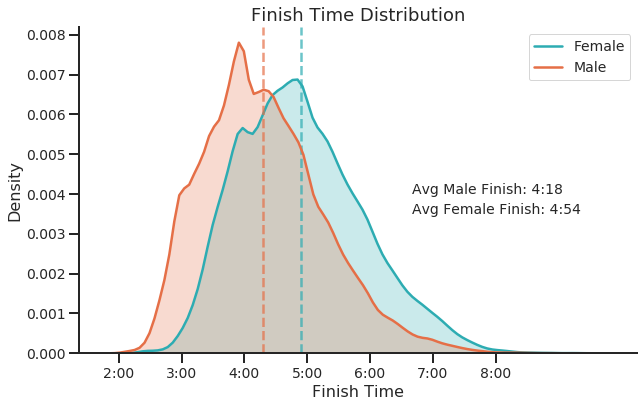

In [23]:
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['gender'] == 'F']['split_Finish']/60, label='Female', shade=True, color=blue)
plt.axvline(means[0], color=blue, linestyle='dashed', alpha=.7)
sns.kdeplot(df[df['gender'] == 'M']['split_Finish']/60, label='Male', shade=True, color=orange)
plt.axvline(means[1], color=orange, linestyle='dashed', alpha=.7)
plt.xticks(np.arange(120, 500, 60), labels=['2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00'])

plt.annotate('Avg Male Finish: 4:18', (400, .004))
plt.annotate('Avg Female Finish: 4:54', (400, .0035))

plt.xlabel('Finish Time')
plt.ylabel('Density')
plt.title('Finish Time Distribution')
#plt.savefig('img/demog/finish_distr.png')
plt.show()

In [24]:
g_ratio = df.groupby(['year', 'gender'])['name'].count()/df.groupby('year')['name'].count()
g_ratio = g_ratio.reset_index()
g_ratio['perc'] = np.round(g_ratio['name']*100)
df1 = g_ratio[g_ratio['gender']=='F']
df2 = g_ratio[g_ratio['gender']=='M']
df1


,year,gender,name,perc
0,2014,F,0.369925,37.0
2,2015,F,0.382463,38.0
4,2016,F,0.385995,39.0
6,2017,F,0.393757,39.0
8,2018,F,0.409475,41.0
10,2019,F,0.417754,42.0


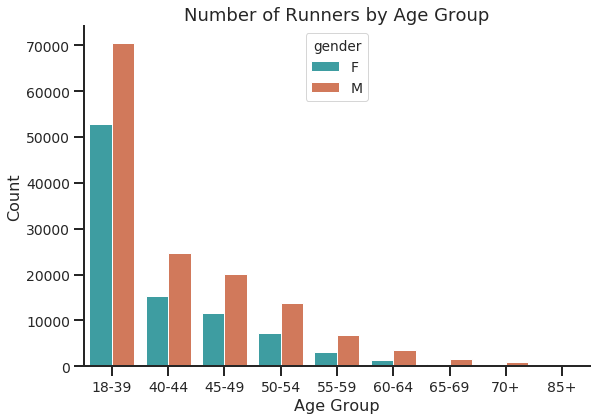

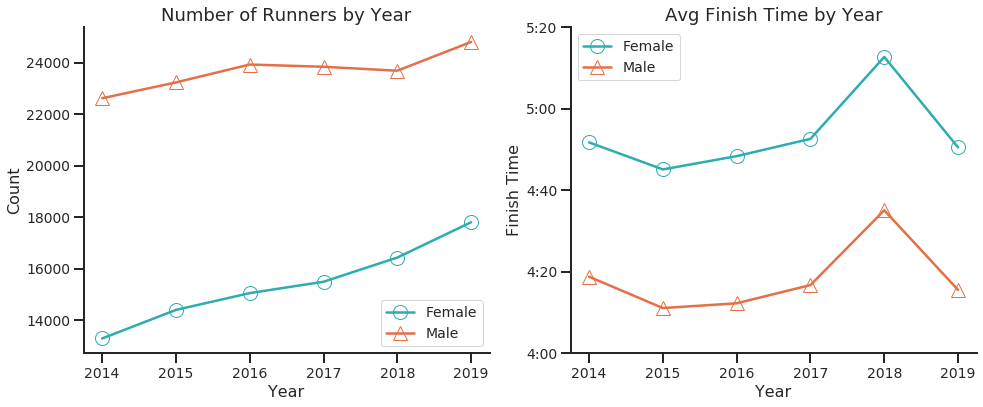

In [25]:
ct = df.groupby(['gender', 'category'])['name'].count()
ct = ct.reset_index()

g = sns.catplot(data=ct, x="category", y="name", hue='gender', 
             kind="bar", palette = [blue, orange],
            hue_order = ['F', 'M'], legend_out=False)

g.set(xlabel='Age Group')
g.set(ylabel='Count')
g.set(title='Number of Runners by Age Group')
g.fig.set_size_inches(10,6)
#g.fig.savefig('img/demog/count_by_age.png')


# analyze average finish times by year for both genders

by_year = df.groupby(['year', 'gender'])['split_Finish'].agg(['count', 'mean'])
by_year = by_year.reset_index()
by_year['year'] = by_year['year'].astype('str')
by_year['split_Finish_min'] = by_year['mean'] /60

df1 = by_year[by_year['gender']=='F']
df2 = by_year[by_year['gender']=='M']


fig, ax = plt.subplots(1, 2, figsize=(16,6))



ax[0].plot('year', 'count', marker='o', label='Female', color=blue, data=df1)
ax[0].plot('year', 'count', marker='^', label='Male', color=orange, data=df2)
ax[0].set_title('Number of Runners by Year')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Count')
ax[0].legend()


ax[1].plot('year', 'split_Finish_min', marker='o', label='Female', color=blue, data=df1)
ax[1].plot('year', 'split_Finish_min', marker='^', label='Male', color=orange, data=df2)
ax[1].set_title('Avg Finish Time by Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Finish Time')
ax[1].set_yticks(np.arange(240, 340, 20))
ax[1].set_yticklabels(['4:00', '4:20', '4:40', '5:00', '5:20'])
ax[1].legend()


#plt.savefig('img/demog/by_year.png')
plt.show()
